***
# Dipole Moment Determination From Near-Field Data via Stochastic Gradient Descent
***

### By Andrew Mentges
### amentges@captechu.edu
### Date 3/15/22

****
# Simulator
***
Define the simulator. This will be the class that we will use to develop our data for validating the dipole moment machine learning model.

## Constructor
`bf_simulator(distances, delta)`
* `distances` - numpy list of distances in meters along the X-Axis where test measurements would be made. Typical distances would be `[1, 1.33, 1.66, 1.99]`
* `delta` - The angle of rotation in degrees. For example, a test where the instrument is rotated 30 degrees at every measurement point would have a delta  of 30

## Methods
`add_dipole(mlocation_x, mlocation_y, mlocation_z, mval_x, mval_y, mval_z)`

Method that will generate B-Field data from the supplied dipole moment information and then add those generated fields to the internally stored B-Field data
* `mlocation_x` - The X-axis position of the dipole moment to be added. Units are in meters. Value should be inside the area described by the distances.
* `mlocation_y` - The Y-axis position of the dipole moment to be added. Units are in meters. Value should be inside the area described by the distances.
* `mlocation_z` - The Z-axis position of the dipole moment to be added. Units are in meters. Value should be inside the area described by the distances.
* `mval_x` - The X-axis value of the dipole moment to be added. Units are in $Amp\cdot meters^{2}$
* `mval_y` - The Y-axis value of the dipole moment to be added. Units are in $Amp\cdot meters^{2}$
* `mval_z` - The Z-axis value of the dipole moment to be added. Units are in $Amp\cdot meters^{2}$

`plot(axis, plevels)`

Method for plotting the internal B-Field for a specific axis
* `axis` - Axis to be plotted. Values can be "X", "Y", "Z". For example, `axis="X"`
* `plevels` - Number of contour levels for the plot that will be generated

`get_data`

Method for getting ordered training data. Returns a tuple of numpy arrays such that Position, BField = `model.get_data()`

Where Position about have the format of [[X1, Y1, Z1], [X2, Y2, Z2],...] and BField would have the format of [[Bx1, By1, Bz1], [Bx2, By2, Bz2],...]

Position will have the units of meters and Bfield values would have the units of Nano-Tesla


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

class bf_simulator:
  def __init__(self, distances, delta):
    self.distances = distances
    self.angle_delta = delta
    self.poles = 0

    #Create the observer distance array
    self.dist_array = []
    for angle in range(0, 360, self.angle_delta):
      for pos in distances:   
        w = self.generate_position(pos, 0, 0, angle)
        self.dist_array.append(w)

    # Create the bfield matrix
    self.field_array = []    
    for positions in self.dist_array:
      w = self.get_bfield(positions[0], positions[1], positions[2], 0, 0, 0, 0, 0, 0)
      self.field_array.append(w)

    # Generate column vectors of distances
    self.x_pos = np.array([row[0] for row in self.dist_array])
    self.y_pos = np.array([row[1] for row in self.dist_array])
    self.z_pos = np.array([row[2] for row in self.dist_array])

    # Column vectors that will hold values of b-field
    self.x_val = []    
    self.y_val = []    
    self.z_val = []  

  # Create a vector of observer positions
  def generate_position(self, distx, disty, distz, theta):  
    theta = np.radians(theta)
      
    original_pos = np.array([[distx, disty, distz]]).T  
    rz = np.array([[np.cos(theta), -1 * np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
    result_val = np.matmul(rz, original_pos)

    x = result_val[0, 0]
    y = result_val[1, 0]
    z = result_val[2, 0]
  
    retval = [x, y, z]

    return retval
  
  # add a bfield due to a dipole moment to the total bfield
  def add_dipole(self, mlocation_x, mlocation_y, mlocation_z, mval_x, mval_y, mval_z):
    #increment the number of poles
    self.poles = self.poles + 1

    new_field = []
    for positions in self.dist_array:
      new_field.append(self.get_bfield(positions[0], positions[1], positions[2], mval_x, mval_y, mval_z, mlocation_x, mlocation_y, mlocation_z))      

    self.field_array = np.add(self.field_array, new_field)
    self.x_val = [row[0] for row in self.field_array]
    self.y_val = [row[1] for row in self.field_array]
    self.z_val = [row[2] for row in self.field_array]

  # Helper function to generate a b-field at the position of the observer for a given
  # dipole moment at a specific location. Units are meters & amp-m^2
  def get_bfield(self, obs_x, obs_y, obs_z, mx, my, mz, mpos_x, mpos_y, mpos_z):

    mu_0 = (4.0 * np.pi) * 10.0**(-7.0)
    mu_denom = (4.0 * np.pi)

    L = mx * (obs_x - mpos_x) + my *(obs_y - mpos_y) + mz *(obs_z - mpos_z)
    P = np.sqrt((obs_x - mpos_x)**2 + (obs_y - mpos_y)**2 + (obs_z - mpos_z)**2)

    #Check for a divide by zero
    if P == 0:
      #set it to a super small number if it is zero
      P = 1e-16

    Bx = (mu_0/mu_denom) * ((3*(obs_x - mpos_x))/P**5) * L - (mu_0/mu_denom) * (mx/P**3)
    By = (mu_0/mu_denom) * ((3*(obs_y - mpos_y))/P**5) * L - (mu_0/mu_denom) * (my/P**3)
    Bz = (mu_0/mu_denom) * ((3*(obs_z - mpos_z))/P**5) * L - (mu_0/mu_denom) * (mz/P**3)

    return [Bx, By, Bz]

  # Create a contour plot of the b-field that has been calculated
  def plot(self, axis='X', plevels=20):
    
    ngridx = 200
    ngridy = 200
    
    x = self.x_pos
    y = self.y_pos

    if axis=='X':
      z = (x * 0) + self.x_val
    if axis=='Y':
      z = (x * 0) + self.y_val
    if axis=='Z':
      z = (x * 0) + self.z_val

    fig, ax2= plt.subplots(nrows=1)

    # -----------------------
    # Interpolation on a grid
    # -----------------------
    # A contour plot of irregularly spaced data coordinates
    # via interpolation on a grid.

    # Create grid values first.
    xi = np.linspace(-2.1, 2.1, ngridx)
    yi = np.linspace(-2.1, 2.1, ngridy)

    # Perform linear interpolation of the data (x,y)
    # on a grid defined by (xi,yi)
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    # Note that scipy.interpolate provides means to interpolate data on a grid
    # as well. The following would be an alternative to the four lines above:
    #from scipy.interpolate import griddata
    #zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')



    # ----------
    # Tricontour
    # ----------
    # Directly supply the unordered, irregularly spaced coordinates
    # to tricontour.

    ax2.tricontour(x, y, z, levels=plevels, linewidths=0.5, colors='k')
    cntr2 = ax2.tricontourf(x, y, z, levels=plevels, cmap="plasma")

    strDisplay = axis + "-Axis, Poles: %d"

    fig.colorbar(cntr2, ax=ax2)
    ax2.plot(x, y, 'ko', ms=3)
    ax2.set(xlim=(-2, 2), ylim=(-2, 2))
    ax2.set_title(strDisplay % self.poles)

    plt.xlabel("X-Axis")
    plt.ylabel("Y-Axis")
    plt.subplots_adjust(hspace=0.5)
    plt.show()

  # Get the ordered data for training purposes
  def get_data(self):
    return self.dist_array, self.field_array

***
# Regression Model
***
A machine learning model that we will use to try to estimate the effective dipole moment from a given set of position data and measured magnetic flux density at said position. This model assumes that the dipole moments are located at the origin of the system coordinates.

## Constructor

Instantiaion of the model.

`DipoleRegressor(num_poles, l_rate=1000)`
* `num_poles` - the number of poles within the model (weights), that will be used to calculate the B-Field for a specific input (position). Currently only use 1.
* `l_rate` - Learning rate that will be applied the to calculated gradient. This will affect how quickly we converge on a solution. Too high of a number will cause overshoot and poor settling time. Too low of a number will require a larger number of epochs to train the model.

## Methods

`DipoleRegressor(inputs)`

This will generate a predicted B-Field from the supplied input. 
* `inputs` - Should be in the form of, `[x, y, z]`. Where `x, y, z` are values positions where the b-field would be observed, or predicted. Units are in meters. 

This method will return a value in the form of `[Bx, By, Bz]`. These are the predicted B-Field components at the input value with units of Nano-Tesla. This prediction should converge towards the correct solution after a sufficient amount of training.

`train(x, y)`

This method will attempt to train the model to predict the correct b-field.
* `x` - The position of the b-field that will be predicted by the model. Should be in the form of, `[x, y, z]`. Where `x, y, z` are values positions where the b-field would be observed, or predicted. Units are in meters.
* `y` - The ground truth. This will be what the correct value of the B-Filed will be for the given inupt. It should have the form of `[Bx, By, Bz]`. These are the predicted B-Field components at the input value with units of Nano-Tesla.

## Properties

`weights`

This is the tensor representing the magnetic dipole moment located at the origin of the coordinate system. When the training loss is low enough, this tensor should converge on the solution of the dipole moment of the test article. If there are multiple moments then the user would need to sum the representative x, y & z axis values for the effective dipole moment at the origin.



In [48]:
from logging import logProcesses
import tensorflow as tf
import numpy as np


print("TensorFlow version:", tf.__version__)

class DipoleRegressor:
  def __init__(self, num_poles, l_rate=0.1):
    w_shape = (num_poles, 3)
    w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
    self.w = tf.Variable(w_initial_value, trainable=True)
    self.learning_rate = l_rate
    # The model will use stochastic gradient descent
    self.opt = tf.keras.optimizers.SGD(learning_rate=l_rate)
    self.loss_object = tf.keras.losses.MeanSquaredError()    

  def __call__(self, inputs):
    
    # Make sure the inputs are in a tensor format
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    # Define P
    p = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(inputs)), name="define P")    
    #Define L
    l = tf.math.reduce_sum(tf.math.multiply(self.w, inputs))
    # Define base mu terms
    mu_term = tf.constant(((4.0 * np.pi) * 10.0**(-7.0)) / (4.0 * np.pi))
    mu3 = tf.constant(tf.math.scalar_mul(3.0, mu_term))
    
    # Calculate the B-Field at the supplied position (inputs)
    retval = tf.math.scalar_mul( l, tf.math.scalar_mul( mu3 , tf.math.scalar_mul(tf.math.divide(1.0, tf.math.pow(p, 5.0)), inputs)))- tf.math.scalar_mul( mu_term, tf.math.scalar_mul(tf.math.divide(1.0, tf.math.pow(p,3.0)), self.w))
    
    return tf.math.reduce_sum(retval, 0)
    
  @property
  def weights(self):
    return [self.w]

  def dipole(self):
    return tf.math.reduce_sum(self.w, 0)

  def train(self, x, y):
    
    with tf.GradientTape() as tape:      
      # Determine the loss dx/dy while recording math operations
      loss = self.loss_object(self(x), y)
    
    gradients = tape.gradient(loss, self.w)
    self.update_weights(gradients, self.w)
    
    scaled_loss = tf.math.scalar_mul( 1.0e9, loss)
    return scaled_loss

  def update_weights(self, gradients, weights):
    
    #print(gradients.numpy())

    # rescale gradients from nano-tesla range to am^2 range
    rscale = tf.Variable(tf.math.scalar_mul(1.0e9, gradients))

    # apply learning rate
    delt = tf.Variable(tf.math.scalar_mul(self.learning_rate, rscale))
    
    self.w.assign_sub(delt)
    



    


TensorFlow version: 2.8.0


Add a dipole moment to the simulator and plot the resultant b-field.

In [49]:

sim = bf_simulator(distances=[1, 1.33, 1.66, 1.99], delta=30)

xpole = 0.1
ypole = 0.2
zpole = -0.6

sim.add_dipole(0.0, 0, 0, xpole, 0, 0)
sim.add_dipole(0.0, 0, 0, 0, ypole, 0)
sim.add_dipole(0.0, 0, 0, 0, 0, zpole)



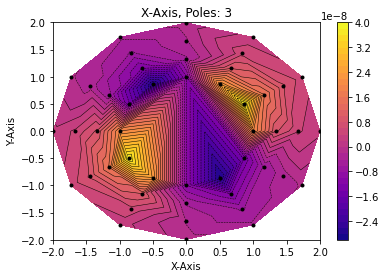

In [50]:
sim.plot(axis='X', plevels=40)

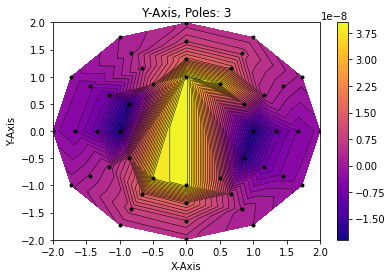

In [51]:
sim.plot(axis='Y', plevels=40)

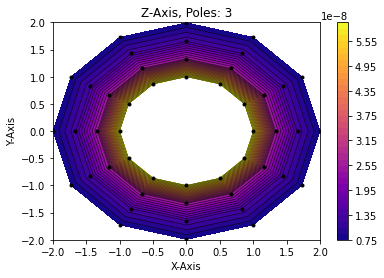

In [52]:
sim.plot(axis='Z', plevels=40)

Grab the simulated test data.

In [53]:
positions, values = sim.get_data()

Shuffle the simulated test data in preparation for stochastic gradient descent.

In [54]:
import random

mapIndexPosition = list(zip(positions, values))
random.shuffle(mapIndexPosition)
positions, values = zip(*mapIndexPosition)

Create the predictive model.

In [55]:
reg_model = DipoleRegressor(num_poles=1, l_rate=1000)


Create the training loop.

In [56]:
epochs = 100

for i in range(epochs):

  for x in range(len(values)):
    loss = reg_model.train(positions[x], values[x])    

  if i % 20 == 0:
    print("Epoch: ", i)
    print("MSE: ", loss.numpy())

  if i == 99:
    print("MSE: ", loss.numpy())   

Epoch:  0
MSE:  1.5788279090676004e-06
Epoch:  20
MSE:  2.3924232182599674e-08
Epoch:  40
MSE:  4.407259662713159e-10
Epoch:  60
MSE:  8.119579043426377e-12
Epoch:  80
MSE:  1.5008220085703965e-13
MSE:  3.754992502778763e-15


Show the predicted values of the magnetic dipole at the origin [X, Y, X]

In [57]:
print(reg_model.dipole().numpy())

[ 0.09999994  0.19999972 -0.5999667 ]


In [58]:
est = reg_model.dipole()

x_error = ((xpole - reg_model.dipole().numpy()[0])/xpole) * 100.0
y_error = ((ypole - reg_model.dipole().numpy()[1])/ypole) * 100.0
z_error = ((zpole - reg_model.dipole().numpy()[2])/zpole) * 100.0
xpercent = 100 - x_error
ypercent = 100 - y_error
zpercent = 100 - z_error
print("Percentage Accuracy X-axis", xpercent)
print("Percentage Accuracy Y-axis", ypercent)
print("Percentage Accuracy Z-axis", zpercent)

Percentage Accuracy X-axis 99.99994188547134
Percentage Accuracy Y-axis 99.99985992908478
Percentage Accuracy Z-axis 99.99445080757141


In [59]:
print(reg_model.dipole().numpy())

[ 0.09999994  0.19999972 -0.5999667 ]


In [60]:
print(reg_model.w.numpy())

[[ 0.09999994  0.19999972 -0.5999667 ]]
